<a href="https://colab.research.google.com/github/philipjamison08/EM-622/blob/main/final_project_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import os
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import networkx as nx
import textwrap as tw


In [ ]:
yellow_cab_base = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_@@.parquet'
# August 2022 Is Latest Dataset
years = range(2022,2023)
months = range(1,9)
for y in years:
  for m in months:
    if y >= 2022 and m >= 9:
      continue
    else:
      yellow_cab_url = yellow_cab_base.replace('@@', '{}-{}'.format(str(y), str(m).zfill(2)))
      try:
        df = pd.concat([df, pd.read_parquet(yellow_cab_url, engine = 'fastparquet')])
      except:
        df = pd.read_parquet(yellow_cab_url, engine = 'fastparquet' )


In [ ]:
zone_maps_url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
gpdf = gpd.read_file(zone_maps_url)

In [ ]:
df_clean = df.query('total_amount != 0')
df_clean = df_clean[df_clean['tpep_pickup_datetime'] > '2022-01-01'] 
df_clean = df_clean[df_clean['tpep_dropoff_datetime'] < '2022-09-02']
df_clean['meter_time'] = df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']
df_clean['meter_time'] = df_clean['meter_time'].astype('timedelta64[m]')
df_clean['total_amount'] = df_clean['total_amount'].map(lambda x: -1 * x if x < 0 else x)
df_clean = df_clean[df_clean['trip_distance'] > 0] 
df_clean = df_clean[(df_clean['PULocationID'].isin([x for x in range(0,264)])) & (df_clean['DOLocationID'].isin([x for x in range(0,264)])) ]
 

In [ ]:
trip_counts_start_loc = df_clean.copy()[['PULocationID', 'DOLocationID']]
trip_counts_start_loc = trip_counts_start_loc.groupby(by = ['PULocationID']).count()
trip_counts_start_loc = trip_counts_start_loc.reset_index()
trip_counts_start_loc = trip_counts_start_loc.rename(columns = {'PULocationID' : 'location_id', 'DOLocationID' : 'counts'})

In [ ]:
gpdf['location_id'] = gpdf['location_id'].astype('int')
gpdf_pu = pd.merge(left = gpdf, left_on = 'location_id', right = trip_counts_start_loc, right_on = 'location_id', how = 'left')
gpdf_pu['counts'] = np.log10(gpdf_pu['counts'])

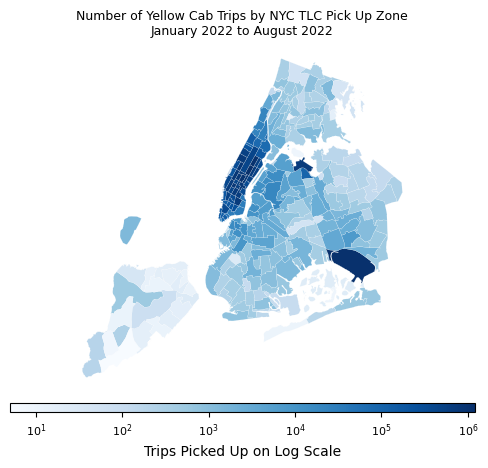

In [ ]:
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2.5%", pad=0.1)

gpdf_pu.plot(column = 'counts', 
            ax = ax, 
            legend = True, 
            cmap = 'Blues', 
            edgecolor="white",
            linewidth = 0.1,
            cax = cax,
            legend_kwds = {'label' : 'Trips Picked Up on Log Scale',
                            'format':"$10^%.0f$",
                            'orientation' : 'horizontal'})


cax.tick_params(labelsize = 8)
ax.axis('off')
ax.set_title('Number of Yellow Cab Trips by NYC TLC Pick Up Zone\nJanuary 2022 to August 2022', fontsize = 9 )
#plt.savefig('num_trips_pu_log.png')
plt.show()

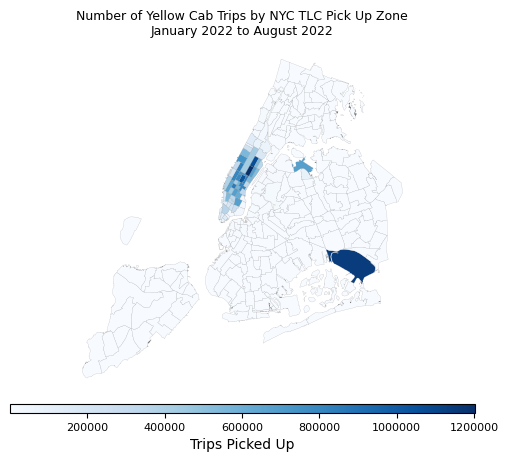

In [ ]:
gpdf_pu = pd.merge(left = gpdf, left_on = 'location_id', right = trip_counts_start_loc, right_on = 'location_id', how = 'left')
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2.5%", pad=0.1)

gpdf_pu.plot(column = 'counts', 
            ax = ax, 
            legend = True, 
            cmap = 'Blues', 
            edgecolor="grey",
            linewidth = 0.1,
            cax = cax,
            legend_kwds = {'label' : 'Trips Picked Up',
                            'format':"%.0f",
                            'orientation' : 'horizontal'})


cax.tick_params(labelsize = 8)
ax.axis('off')
ax.set_title('Number of Yellow Cab Trips by NYC TLC Pick Up Zone\nJanuary 2022 to August 2022', fontsize = 9 )
#plt.savefig('num_trips_pu_nolog.png')
plt.show()

In [ ]:
trip_counts_drop_loc = df_clean.copy()[['PULocationID', 'DOLocationID']]
trip_counts_drop_loc = trip_counts_drop_loc.groupby(by = ['DOLocationID']).count()
trip_counts_drop_loc = trip_counts_drop_loc.reset_index()
trip_counts_drop_loc = trip_counts_drop_loc.rename(columns = {'DOLocationID' : 'location_id', 'PULocationID' : 'counts'})

In [ ]:
gpdf_do = pd.merge(left = gpdf, left_on = 'location_id', right = trip_counts_drop_loc, right_on = 'location_id', how = 'left')
gpdf_do['counts'] = np.log10(gpdf_do['counts'])

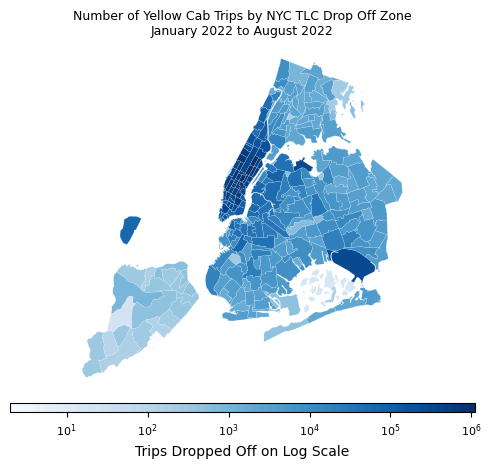

In [ ]:
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2.5%", pad=0.1)

gpdf_do.plot(column = 'counts', 
            ax = ax, 
            legend = True, 
            cmap = 'Blues', 
            edgecolor="white",
            linewidth = 0.1,
            cax = cax,
            legend_kwds = {'label' : 'Trips Dropped Off on Log Scale',
                            'format':"$10^%.0f$",
                            'orientation' : 'horizontal'})


cax.tick_params(labelsize = 8)
ax.axis('off')
ax.set_title('Number of Yellow Cab Trips by NYC TLC Drop Off Zone\nJanuary 2022 to August 2022', fontsize = 9 )
#plt.savefig('num_trips_do_log.png')
plt.show()

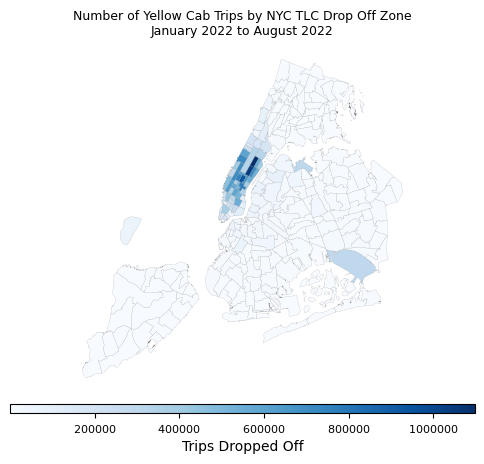

In [ ]:
gpdf_do = pd.merge(left = gpdf, left_on = 'location_id', right = trip_counts_drop_loc, right_on = 'location_id', how = 'left')
fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="2.5%", pad=0.1)

gpdf_do.plot(column = 'counts', 
            ax = ax, 
            legend = True, 
            cmap = 'Blues', 
            edgecolor="grey",
            linewidth = 0.1,
            cax = cax,
            legend_kwds = {'label' : 'Trips Dropped Off',
                            'format':"$%.0f$",
                            'orientation' : 'horizontal'})


cax.tick_params(labelsize = 8)
ax.axis('off')
ax.set_title('Number of Yellow Cab Trips by NYC TLC Drop Off Zone\nJanuary 2022 to August 2022', fontsize = 9 )
#plt.savefig('num_trips_do_no_log.png')
plt.show()


In [ ]:
print('The Top Five Pick-Up Zones Are:')
gpdf_pu.sort_values(by = ['counts'], ascending = False)[['zone', 'borough', 'location_id','counts']][:5]

The Top Five Pick-Up Zones Are:


,zone,borough,location_id,counts
237,Upper East Side South,Manhattan,237,1201947.0
136,JFK Airport,Queens,132,1143338.0
236,Upper East Side North,Manhattan,236,1070297.0
160,Midtown Center,Manhattan,161,1035088.0
185,Penn Station/Madison Sq West,Manhattan,186,854853.0


In [ ]:
print('The Top Five Drop Off Zones Are:')
gpdf_do.sort_values(by = ['counts'], ascending = False)[['zone', 'borough', 'location_id','counts']][:5]

The Top Five Drop Off Zones Are:


,zone,borough,location_id,counts
236,Upper East Side North,Manhattan,236,1097903.0
237,Upper East Side South,Manhattan,237,1040791.0
160,Midtown Center,Manhattan,161,931910.0
164,Murray Hill,Manhattan,170,773507.0
229,Times Sq/Theatre District,Manhattan,230,753852.0


In [ ]:
gpdf_pu_vs_do = pd.merge(left = gpdf, left_on = 'location_id', right = trip_counts_start_loc, right_on = 'location_id', how = 'left')
gpdf_pu_vs_do = gpdf_pu_vs_do.rename(columns = {'counts' : 'pu_counts'})
gpdf_pu_vs_do = pd.merge(left = gpdf_pu_vs_do, left_on = 'location_id', right = trip_counts_drop_loc, right_on = 'location_id', how = 'left' )
gpdf_pu_vs_do = gpdf_pu_vs_do.rename(columns = {'counts' : 'do_counts'})

In [ ]:
gpdf_pu_vs_do['compare'] = gpdf_pu_vs_do['do_counts'] - gpdf_pu_vs_do['pu_counts']
gpdf_pu_vs_do['compare'] = gpdf_pu_vs_do['compare'].map(lambda x: 'Drop Offs' if x > 0 else 'Pick Ups')

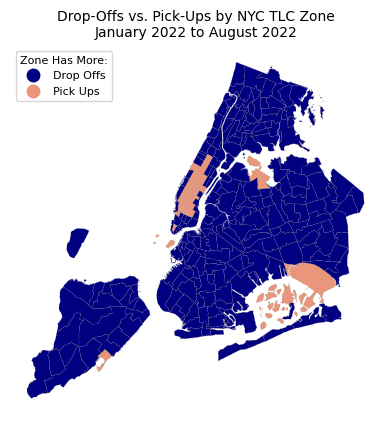

In [ ]:
fig, ax = plt.subplots(1, 1)

#cax = divider.append_axes("bottom", size="2.5%", pad=0.1)

gpdf_pu_vs_do.plot(column = 'compare', 
                    ax = ax, 
                    #categorical=True,
                    cmap = ListedColormap(['navy', 'darksalmon']),
                    edgecolor = 'grey',
                    cax = cax,
                    linewidth = 0.1, 
                    legend = True,
                    legend_kwds = { 'title' : 'Zone Has More:' ,                                  
                                    'loc' : 'upper left',
                                    'fontsize' : 8}

                    )


plt.setp(ax.get_legend().get_title(),fontsize='8')
ax.axis('off')
ax.set_title('Drop-Offs vs. Pick-Ups by NYC TLC Zone\nJanuary 2022 to August 2022', fontsize = 10)
#plt.savefig('do_vs_pu.png')
plt.show()

In [ ]:
idboro = gpdf[['location_id', 'zone', 'borough']]

In [ ]:
pu_do_df = df_clean[['PULocationID', 'DOLocationID']].reset_index().rename(columns = {'index' : 'counts'})
pu_do_df = pu_do_df.groupby(by = ['PULocationID', 'DOLocationID']).count().reset_index()


In [ ]:
top5_pu = gpdf_pu.sort_values(by = ['counts'], ascending = False)[['zone', 'borough', 'location_id','counts']][:5]

In [ ]:
top5_pu_graph = pd.merge(left = top5_pu, left_on = 'location_id',  right = pu_do_df, right_on = 'PULocationID', how = 'left'  ).rename(columns = {'counts_x' : 'total_counts', 'counts_y' : 'edge_counts'})
top5_pu_graph = top5_pu_graph.drop(columns = ['zone', 'borough', 'location_id'])
top5_pu_graph = pd.merge(left = top5_pu_graph, left_on = 'DOLocationID', right = idboro, right_on = 'location_id', how = 'left').rename(columns = {'zone' : 'DO_zone', 'borough' : 'DO_boro'})

In [ ]:
top5_pu_graph_by_boro = top5_pu_graph.drop(columns = ['total_counts', 'DO_zone', 'location_id', 'DOLocationID']).groupby(by = ['PULocationID', 'DO_boro'] ).sum()
top5_pu_graph_by_boro = top5_pu_graph_by_boro.reset_index()
top5_pu_graph_by_boro = pd.merge(left = top5_pu_graph_by_boro, left_on = 'PULocationID', right = idboro[['location_id', 'zone']], right_on = 'location_id', how = 'left').drop(columns = ['location_id', 'PULocationID']).rename(columns = {'zone' : 'PU_zone'})

In [ ]:
top5_pu_graph_by_boro = top5_pu_graph_by_boro.rename(columns = {'DO_boro' : 'target', 'PU_zone' : 'source', 'edge_counts' : 'width'})


In [ ]:
Gpu = nx.from_pandas_edgelist(top5_pu_graph_by_boro, edge_attr = 'width')
Gpu_widths = [np.log(i['width'])/10 for i in dict(Gpu.edges).values()]

In [ ]:
Gpu_node_colors = []
Gpu_node_sizes = []
Gpu_node_labels = {}
for n in list(Gpu.nodes):
    if n in top5_pu['zone'].values.tolist():
        Gpu_node_colors.append('#03adfc'.upper())
        Gpu_node_sizes.append( top5_pu[['zone', 'counts']].query('zone == @n')['counts'].iloc[0] / 1000)
    else:
        Gpu_node_colors.append('#fc2403'.upper())
        Gpu_node_sizes.append(top5_pu_graph_by_boro[['target', 'width']].groupby(by = ['target']).sum().reset_index().query('target == @n')['width'].iloc[0] / 1000)

    Gpu_node_labels[n] = '\n'.join(tw.wrap(n.replace('/', ' / '), width = 10))


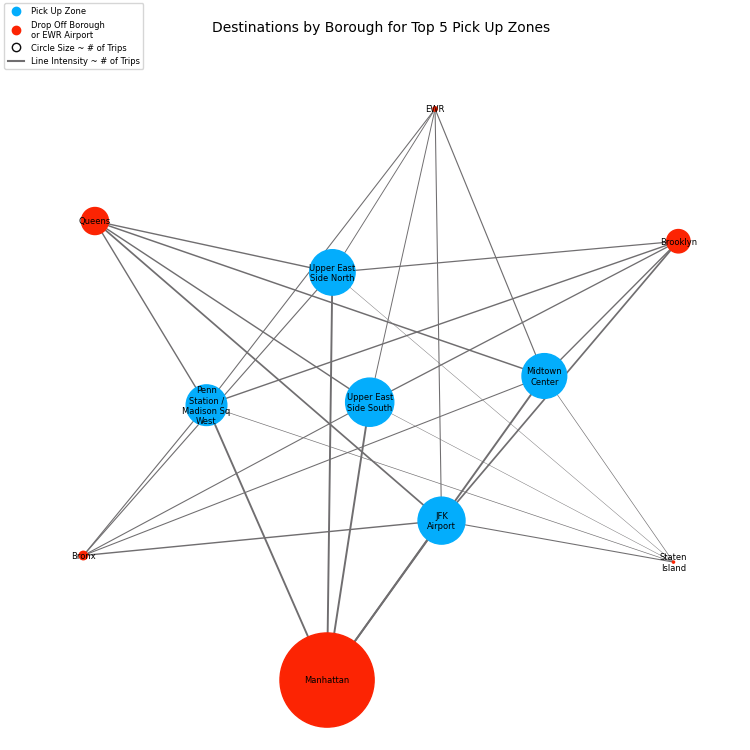

In [ ]:
fig = plt.figure(1, figsize = (7.5, 7.5))
ax = fig.add_subplot(1,1,1)
ax1 = fig.add_subplot(1,2,1)
Gpu_options = {
    'node_color' : Gpu_node_colors,
    'with_labels' : True,
    'labels' : Gpu_node_labels,
    'font_size' : 6,
    'node_size' : Gpu_node_sizes,
    'width' : Gpu_widths,
    'edge_color' : '#706e70'.upper()
    
}

color_labels = {
    '#03adfc'.upper() : 'Pick Up Zone',
    '#fc2403'.upper() : 'Drop Off Borough\nor EWR Airport'

}

Gpu_graph= nx.draw_networkx(Gpu, ax = ax ,**Gpu_options)

for color in color_labels:
    ax1.plot([0], [0], color = color, label = color_labels[color], marker = 'o', linewidth = 0)

## Plotting Size 
ax1.plot([0], [0], color = '#0d0c0d'.upper(), label = 'Circle Size ~ # of Trips', marker = 'o', linewidth = 0, fillstyle = 'none')

## Plotting Strength 
ax1.plot([0], [0], color = '#706e70'.upper(), label = 'Line Intensity ~ # of Trips' )





ax.axis('off')
fig.suptitle('Destinations by Borough for Top 5 Pick Up Zones', size =   10)
ax1.set_visible(False)
fig.legend(loc = 2, prop={'size': 6})
fig.tight_layout()
plt.savefig('pu_boro_nw_map.png')
plt.show()
